# TS7 Filtrado digital lineal de ECG

## 1. Introducción:
El presente trabajo explora distintos tipos de filtros para mitigar el efecto de diversas fuentes de ruido sobre una señal de electrocardiograma registrado durante una prueba de esfuerzo.

Para realizar un electrocardiograma, se colocan electrodos en las extremidades del cuerpo y sobre la superficie del torso. Se trata de una técnica poco invasiva y de bajo costo utilizada ampliamente para analizar la funcionalidad del corazón. Esta señal esta contaminada por diversas fuentes, siendo estas:
1. Ruido causado por el movimiento de los electrodos (Alta frecuencia).
2. Ruido muscular (Alta frecuencia).
3. Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia).


## 2. Experimentación:
Para llevar a cabo el filtrado de as diversas fuentes que contaminan la señal de ECG, se establece una plantilla de diseño para los filtros digitales. Dicha plantilla debe ser tal que logre que la señal del ECG se asemeje a los latidos promedio en cuanto a la suavidad de los trazos y nivel isoeléctrico nulo. Para ello, se consideraron las siguientes morfologías:


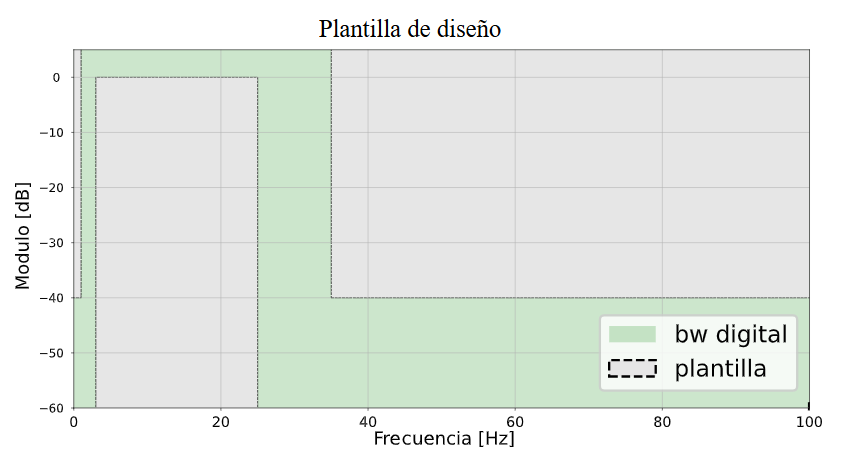
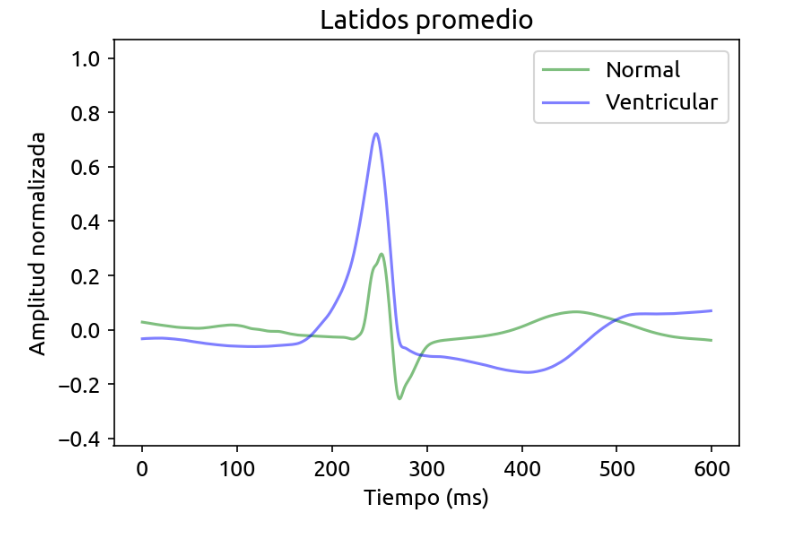
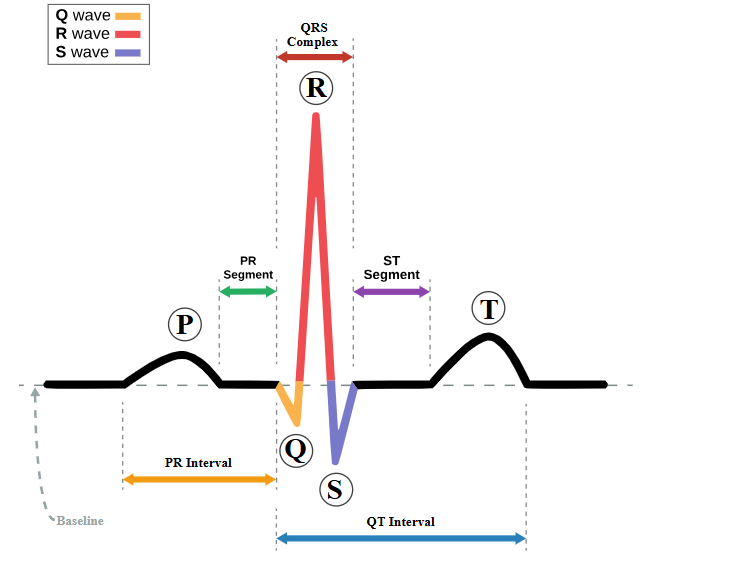



By Created by Agateller (Anthony Atkielski), converted to svg by atom. - SinusRhythmLabels.png, Public Domain, Link

La plantilla de diseño de los filtros se costruye como se detalla a continuación:

### 2.1 Plantilla de diseño:

In [13]:
#############
# Plantilla #
#############
 
nyq_frec = fs/2
ripple = 1 # dB
atenuacion = 40 # dB
 
ws1 = ?? # Hz
wp1 = ?? # Hz
wp2 = ?? # Hz
ws2 = ?? # Hz
 
# plantilla normalizada a Nyquist en dB
frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
 
# convertimos a veces para las funciones de diseño
gains = 10**(gains/20)

SyntaxError: invalid syntax (1850560993.py, line 9)

Como se logra apreciar, la plantilla de diseño esta caracterizada por varios parametros que aseguran que el diseño del filtro pasabanda preserve los componentes relevsntes dedl ECG y suprima contaminaciones típicas. 
Banda de paso: Para obtener el ancho de banda útil de la señal, se realizó en primer lugar una inspección de la señal en frecuencia, lo que permitió visualizar que el espectro acumulaba la mayor parte de la energía antes de los 40 Hz. A su vez, se calculó el ancho de banda útil como la frecuencia a la cual se acumulaba el 98% de la densidad espectral de potencia, obteniendose un valor cercano a 35 Hz. A su vez, se consideró la fisiología de las componentes principales del ECG (ondas P, QRS y T), que están contenidas en un rango de entre 0,5 Hz y 40 Hz proximadamente. En particular, la onda P y la T son de baja frecuencia (entre 0,5 Hz y 10 Hz), el complejo QRS, que es más abrupto, posee componentes de mayor frecuencia (alcanzan los 15-30 Hz). Teniendo estas consideraciones en cuenta, se definió que ws1 = 0.1 Hz era adecuado para permitir una transición suave desde 0 Hz. En segundo lugar, wp1 = 1.0 Hz como comienzo de la banda de paso, permite atenuar el ruido de bajas frecuecias asociado al movimiento de la línea de base del ECG que se introduce por la respiración. Para el final de la banda de paso, se utilizó 35 Hz, este valor permite que el ancho de banda efectivo de la señal quedé contenido dentro de la banda de paso. Por último, ws2 = 50 Hz determina el momento donde se comienza a atenuar fuertemente la señal, el valor de este parámetro asegura la supresión de inerferencias de corriente alterna.
La elección del ripple de 1dB en la banda pasante permite pequeñass variaciones en la amplitud en frecuencias útiles. Por otro lado, el valor de 40 dB de atenuación permite eliminar bien las componentes indeseadas.

#### 2.11 Implementación de la plantilla utilizando filtros FIR

Se diseñaron "3" filtros FIR utilizando las metodologías de ventanas, cuadrados mínimos y Parks-Mc Clellan-Remez utilizando SciPy.Signal. Luego se verificó que la respuesta en frecuencia respondiera a la pantilla de diseño para finalmente evaluar el rendimiento de cada uno de estos. 

Método de **Ventana** Generalizado
Para implementar un filtrado FIR utilizando el método de ventansa, se utilizó la función **firwin2(numtaps, freq, gain, ...)** de SciPy. Está utiliza el método clásico de ventanas, es decir que aplica una ventana a elección sobre la respuesta ideal truncada para lograr un filtro de fase lineal. El resultado es una aproximación simple a la respuesta deseada, sin embargo el error no esta optimizado estrictamente. Si bien es muy utilizado por su gran simplicidad, sin requerimientos de rendimiento estrictos en cuanto al costo computacional, la precisión de banda no es muy alta y la transición entre la banda de paso y de rechazo es moderada.

"Método de ajuste por **Cuadrados Mínimos**
Este tipo de filtro se implementa mediante la función: **firls(numtaps, bands, desired, ...)**. Encuentra los coeficientes que minimizan el error cuadrático medio entre la respuesta deseada y la obtenida, el resultado de su implementación es una buena aproximación de la respuesta deseada en promedio dentro de cada banda, no obstante, no se garantiza un error bajo en todos los puntos. Se caracteriza por un costo computacional medio, con un una precisión en banda buena y una transición suave."

Algoritmo de intercambio de **Parks-McClellan-Remez**
La implementación de la función **remez(numtaps, bands, derised, ... )** diseña un filtro óptimo en cuanto al error minimax. Esto implica que busca minimizar el máximo error entre la ganancia deseada y la obtenida en lass bandas específicadas. El resultado es un error equioscilante en varios puntos, por lo que la repsuesta es controlada y eficiente. Si bien su costo computacional es alto debido al proceso iterativo, el filtro posee una muyu buena selectividad y trnasiciones muy abruptas en comparación a los dos métodos descritos previamente.

#### 2.12 Implementación de la plantilla utilizando filtros IIR

Los filtros IIR (respuesta infinita al impulso) están conformados por coeficientes de numerados y denominados que forman un polinomio de orden elevado. Cuando el orden del filtro es alto (mayor a 8 aproximadament), el cálculo de la salida puede producir problemas numéricos, como inestabilidad o errores de redondeo porque se produce una cancelación entre los polos y ceros cercanos en el círculo unitario. Para evitar estos problemas, se implementa una técnica denominada descomposición en secciones de segundo orden (SOS). Que divide el filtro en secciones de orden 2, es decir, en filtros más sencillos de solamente 2 polos y dos ceros. El filtro completo se construye como le producto en cascada de todas las secciones. La utilización de esta técnica mejora la estabilidad y precisión numérica. Las funciones incluidas en scipy.signal.iirdesign(..., output='sos') devuelven filtros en este formato.
Se diseñaron 3 filtros IIR empleando las metodologías de Butterworth, Chebyshev tipo I y Cauer (o elíptico) incluidas en scipy.signal. Estos filtros permiten alcanzar especificaciones de mayor exigencia utilizando menor orden, lo que reduce el costo computacional.
Filtro **Butterworth** 
Se diseñó usanod ftype = 'butter'. Se caracteriza por una respuesta suave y monótonamente decreciente tanto en la banda de paso como en la de rechazo. Es una opción altamente robusta cuando se prioriza una respuesta lo más plana posible en la banda de paso ya que no presenta ondulaciones. Sin embargo, la transición entre bandas es más lenta comparada con otros diseños, por lo que requiere un orden mayor si se necesita una selectividad alta.
Filtro **Chebyshev tipo I**
Para implementar un filtro de Cheby, se usó ftype='cheby1'como especificación en iirdesign. Este diseño introduce ondulaciones controladas en la banda de paso (definidas por el parámetro rp), lo que permite una caída más rápida que la de Butterworth. Si se tolera cierta variación en la ganancia dentro de la banda de paso, es una gran opción ya que mejora la selectividad. El costo computacional es bajo debido a que requiere un orden bajo para lograr una buena selectividad.
Filtro **Cauer (Elíptico)**
Este filtro se implementa con ftype='ellip', el filtro introduce ondulaciones tanto en la banda de paso como en la de rechazo, optimizando la selectividad y generando las transiciones más abruptas posibles para el orden dado. Si bien es un diseño más complejo, logra un compromiso entre orden y rendimineto significativamente mejor, a costa de una respuesta altamente no lineal.
Como se puede notar, en los filtros IIR hay un tradeoff entre selectividad y ondulaciones en la respuesta en frecuencia. Si bien tener una gran selectividad es deseable para lograr transiciones más abruptas, la introducción de ondulaciones a la señal significa que ciertas frecuencias de amplifucan o atenúan más de lo esperado, cambiandod la forma de la señal original. Además, si la ganancia no es constante, algunas partes se enfatizan más que otras, lo que produce una distorsión en el espectro.

#### 2.13 Respuesta en frecuencia

C:\Users\iremo\AppData\Local\Temp\ipykernel_9232\4015616495.py:92: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(np.abs(h_butter)), label=f'IIR-Butter (orden {bp_sos_butter.shape[0]})')
C:\Users\iremo\AppData\Local\Temp\ipykernel_9232\4015616495.py:93: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(np.abs(h_cheby)), label=f'IIR-Cheby (orden {bp_sos_cheby.shape[0]})')


NameError: name 'cant_coef' is not defined

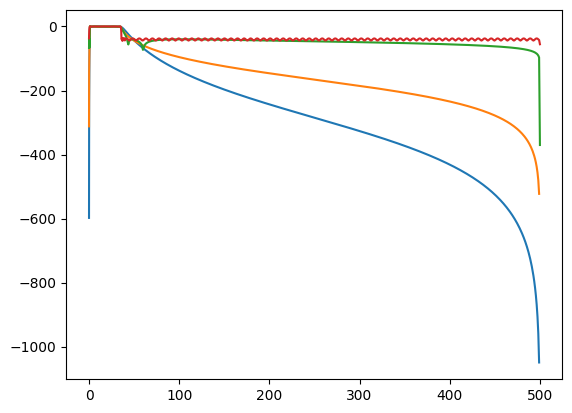

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jun 10 17:47:28 2025

@author: iremo
"""

import numpy as np
from scipy import signal as sig

import matplotlib.pyplot as plt
   
import scipy.io as sio
from scipy.io.wavfile import write
from pytc2.sistemas_lineales import plot_plantilla


def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

#%%


fs_ecg = 1000 # Hz


# ECG con ruido


# para listar las variables que hay en el archivo
sio.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])
N = len(ecg_one_lead)

hb_1 = vertical_flaten(mat_struct['heartbeat_pattern1'])
hb_2 = vertical_flaten(mat_struct['heartbeat_pattern2'])
 
nyq_frec = fs_ecg/2
ripple = 1 # dB
atenuacion = 40 # dB
 
ws1 = 0.1 # Hz
wp1 = 1.0 # Hz
wp2 = 35 # Hz
ws2 = 50 # Hz
 
# plantilla normalizada a Nyquist en dB
frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])

 
# convertimos a veces para las funciones de diseño
gains = 10**(gains/20)

#Diseño de filtros

bp_sos_butter = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=1, gstop=40., analog=False, ftype='butter', output='sos')
bp_sos_cheby = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=1, gstop=40., analog=False, ftype='cheby1', output='sos')
bp_sos_cauer = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=1, gstop=40., analog=False, ftype='ellip', output='sos')

cant_coef1 = 3001


band = [1, 35]  
trans_width = 1    # Width of transition from pass to stop, Hz
numtaps = 2501         # Size of the FIR filter.
edges = [0, band[0] - trans_width, band[0], band[1], band[1] + trans_width , 0.5*fs_ecg]
num_remez = sig.remez(numtaps, edges, [0.01, 1, 0.01], fs=fs_ecg) # (20⋅log(0.01)=-40dB

#num_win =   sig.firwin2(cant_coef1, frecs, gains , window='hann' )

den = 1.0

#Análisis:
    
NN = 1024
w_rad  = np.append(np.logspace(-2, 0.8, NN//4), np.logspace(0.9, 1.6, NN//4) )
w_rad  = np.append(w_rad, np.linspace(40, nyq_frec, NN//2, endpoint=True) ) / nyq_frec * np.pi

w, h_butter = sig.sosfreqz(bp_sos_butter, worN=w_rad)
_, h_cheby = sig.sosfreqz(bp_sos_cheby, worN=w_rad)
_, h_cauer = sig.sosfreqz(bp_sos_cauer, worN=w_rad)
#_, hh_firls = sig.freqz(num_firls, den, worN=w_rad)
_, hh_remez = sig.freqz(num_remez, den, worN=w_rad)
_, hh_win = sig.freqz(num_win, den, worN=w_rad)
w = w / np.pi * nyq_frec  

plt.figure(1)
plt.plot(w, 20 * np.log10(np.abs(h_butter)), label=f'IIR-Butter (orden {bp_sos_butter.shape[0]})')
plt.plot(w, 20 * np.log10(np.abs(h_cheby)), label=f'IIR-Cheby (orden {bp_sos_cheby.shape[0]})')
plt.plot(w, 20 * np.log10(np.abs(h_cauer)), label=f'IIR-Cauer (orden {bp_sos_cauer.shape[0]})')
#plt.plot(w, 20 * np.log10(abs(hh_firls)), label='FIR-ls')
plt.plot(w, 20 * np.log10(abs(hh_remez)), label=f'FIR-remez (Orden {numtaps-1})')
plt.plot(w, 20 * np.log10(abs(hh_win)), label=f'FIR-Win (Orden {cant_coef-1})')
   
plt.title('Filtros FIR e IIR - Respuesta en frecuencia')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.gca().legend()
plt.grid()
plt.axis([0, 60, -60, 1 ]);
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs_ecg)

plt.figure(2)
plt.plot(w, 20 * np.log10(np.abs(h_butter)), label='IIR-Butter' )
plt.plot(w, 20 * np.log10(np.abs(h_cheby)), label='IIR-Cheby' )
plt.plot(w, 20 * np.log10(np.abs(h_cauer)), label='IIR-Cauer' )
#plt.plot(w, 20 * np.log10(abs(hh_firls)), label='FIR-ls')
plt.plot(w, 20 * np.log10(abs(hh_remez)), label='FIR-remez')
plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win')  
plt.title('Respuesta en frecuencias bajas')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.gca().legend()
plt.grid()
plt.axis([0, 2, -55, 4 ]);
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs_ecg)

plt.figure(3)
plt.plot(w, 20 * np.log10(np.abs(h_butter)), label='IIR-Butter' )
plt.plot(w, 20 * np.log10(np.abs(h_cheby)), label='IIR-Cheby' )
plt.plot(w, 20 * np.log10(np.abs(h_cauer)), label='IIR-Cauer' )
#plt.plot(w, 20 * np.log10(abs(hh_firls)), label='FIR-ls')
plt.plot(w, 20 * np.log10(abs(hh_remez)), label='FIR-remez')
plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win')  
plt.title('ZOOM - Respuesta en frecuencias bajas')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.gca().legend()
plt.grid()
plt.axis([0.5, 2, -5, 5 ]);
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs_ecg)

plt.figure(4)
plt.plot(w, 20 * np.log10(np.abs(h_butter)), label='IIR-Butter' )
plt.plot(w, 20 * np.log10(np.abs(h_cheby)), label='IIR-Cheby' )
plt.plot(w, 20 * np.log10(np.abs(h_cauer)), label='IIR-Cauer' )
#plt.plot(w, 20 * np.log10(abs(hh_firls)), label='FIR-ls')
plt.plot(w, 20 * np.log10(abs(hh_remez)), label='FIR-remez')
plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win')  
plt.title('Respuesta en frecuencias altas')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.gca().legend()
plt.grid()
plt.axis([30, 50, -60, 2 ]);
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs_ecg)

plt.figure(5)
plt.plot(w, 20 * np.log10(np.abs(h_butter)), label='IIR-Butter' )
plt.plot(w, 20 * np.log10(np.abs(h_cheby)), label='IIR-Cheby' )
plt.plot(w, 20 * np.log10(np.abs(h_cauer)), label='IIR-Cauer' )
#plt.plot(w, 20 * np.log10(abs(hh_firls)), label='FIR-ls')
plt.plot(w, 20 * np.log10(abs(hh_remez)), label='FIR-remez')
plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win')  
plt.title('ZOOM - Respuesta en frecuencias altas')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.gca().legend()
plt.grid()
plt.axis([32, 37, -10, 5 ]);
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs_ecg)

### 2.14 Interpretación
Las figuras producidas permiten ver la facilidad de los filtros IIR para cumplir con las especificaciones de la plantilla de diseño. Cabe destacar que la función implementada (iirdesign) produce el filtro de orden mínimo necesario para cumplir con las especificaciones solicitadas, por este motivo, observamos que los 3 filtros cumplen con lo pedido, pero el orden de cada uno es diferente. 
Como se predijo, El filtro de Cauer tiene la transición más abrupta, menor orden (menos costo computacional), sin embargo, presenta ripple en la banda de paso y en la banda stop. Estas características lo hacen ideal para diseños en donde se requiere una selectividad alta con un orden mínimo. En cuanto al filtro de Cheby, requirió un orden 7 para cumplir con las especificaciones, como se logra apreciar, la selectividad es peor en comparación al filtro de Cauer, y el ripple en la banda de paso es similar. El costo computacional es ligeramente mayor. Por ultimo, el filtro de Butter tiene una trnsición más ancha, (peor selectividad), atenuación lenta y costo mucho más elevado (orden 15 como mínimo para cumplir) Sin embargo, a diferencia de los anteriores, el ripple es totalmente nulo.
En cuanto a los filtros FIR. La experimentación deja en evidencia su enorme costo computacional e ineficiencia a la hora de cumplir con los requisistos de la plantilla. Observamos que para un orden de 3000, el filtro diseñado por el método de ventanas sigue sin cumplir con lo especificado y su banda de transición es notoriamente menos selectiva. En cuanto el filtro FIR que implementa el método de Parks-McClellan-Remez, observamos una trnasición mucho más abrupta en comparación al implementado por el método de ventanas, no obstante, obsrvamos que en bajas frecuencias no llega a cumplir con los requisitos aún con un orden de 2500.


### 2.15 Exploración por variación de parametros en los filtros FIR


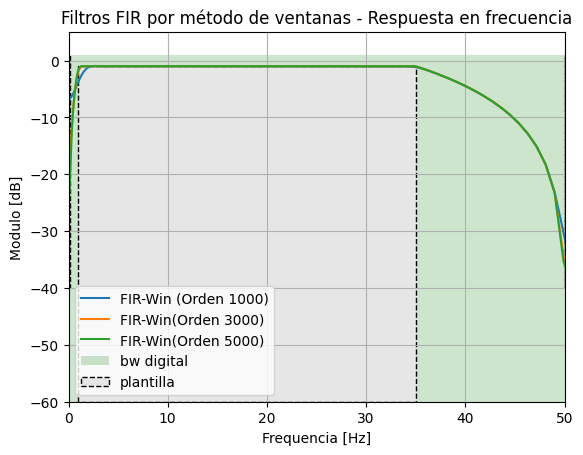

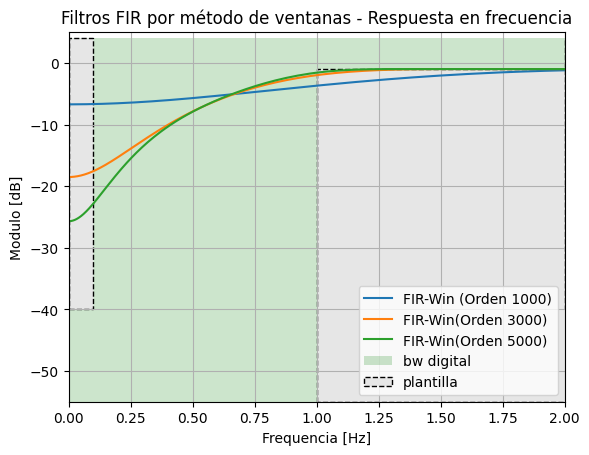

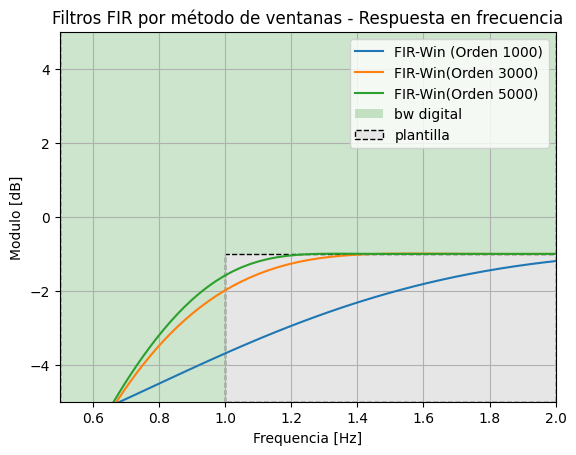

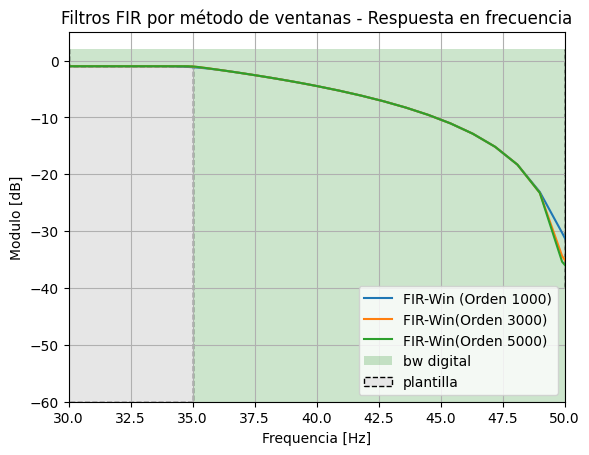

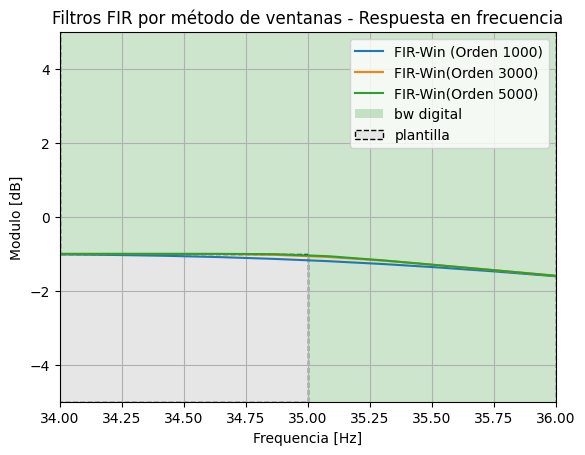

In [3]:
import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.io.wavfile import write
from pytc2.sistemas_lineales import plot_plantilla

def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

fs_ecg = 1000 # Hz

sio.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])
N = len(ecg_one_lead)

nyq_frec = fs_ecg/2
ripple = 1 # dB
atenuacion = 40 # dB
 
ws1 = 0.1 # Hz
wp1 = 1.0 # Hz
wp2 = 35 # Hz
ws2 = 50 # Hz
 
# plantilla normalizada a Nyquist en dB
frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
 
# convertimos a veces para las funciones de diseño
gains = 10**(gains/20)

cant_coef1 = 1001
cant_coef2 = 3001
cant_coef3 = 5001
num_win1 =   sig.firwin2(cant_coef1, frecs, gains , window='hann' )
num_win2 =   sig.firwin2(cant_coef2, frecs, gains , window='hann' )
num_win3 =   sig.firwin2(cant_coef3, frecs, gains , window='hann' )
den = 1.0

#Análisis:
    
NN = 1024
w_rad  = np.append(np.logspace(-2, 0.8, NN//4), np.logspace(0.9, 1.6, NN//4) )
w_rad  = np.append(w_rad, np.linspace(40, nyq_frec, NN//2, endpoint=True) ) / nyq_frec * np.pi

w, hh_win1 = sig.freqz(num_win1, den, worN=w_rad)
w, hh_win2 = sig.freqz(num_win2, den, worN=w_rad)
w, hh_win3 = sig.freqz(num_win3, den, worN=w_rad)

w = w / np.pi * nyq_frec  

plt.figure(1)

plt.plot(w, 20 * np.log10(abs(hh_win1 + 1e-10)), label='FIR-Win (Orden 1000)')  
plt.plot(w, 20 * np.log10(abs(hh_win2 + 1e-10)), label='FIR-Win(Orden 3000)')  
plt.plot(w, 20 * np.log10(abs(hh_win3 + 1e-10)), label='FIR-Win(Orden 5000)')  
plt.title('Filtros FIR por método de ventanas - Respuesta en frecuencia')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.gca().legend()
plt.grid()
plt.axis([0, 50, -60, 1 ]);
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs_ecg)

plt.figure(2)
plt.plot(w, 20 * np.log10(abs(hh_win1 + 1e-10)), label='FIR-Win (Orden 1000)')  
plt.plot(w, 20 * np.log10(abs(hh_win2 + 1e-10)), label='FIR-Win(Orden 3000)')  
plt.plot(w, 20 * np.log10(abs(hh_win3 + 1e-10)), label='FIR-Win(Orden 5000)')  
plt.title('Filtros FIR por método de ventanas - Respuesta en frecuencia')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.gca().legend()
plt.grid()
plt.axis([0, 2, -55, 4 ]);
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs_ecg)

plt.figure(3)
plt.plot(w, 20 * np.log10(abs(hh_win1 + 1e-10)), label='FIR-Win (Orden 1000)')  
plt.plot(w, 20 * np.log10(abs(hh_win2 + 1e-10)), label='FIR-Win(Orden 3000)')  
plt.plot(w, 20 * np.log10(abs(hh_win3 + 1e-10)), label='FIR-Win(Orden 5000)')  
plt.title('Filtros FIR por método de ventanas - Respuesta en frecuencia')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.gca().legend()
plt.grid()
plt.axis([0.5, 2, -5, 5 ]);
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs_ecg)

plt.figure(4)
plt.plot(w, 20 * np.log10(abs(hh_win1 + 1e-10)), label='FIR-Win (Orden 1000)')  
plt.plot(w, 20 * np.log10(abs(hh_win2 + 1e-10)), label='FIR-Win(Orden 3000)')  
plt.plot(w, 20 * np.log10(abs(hh_win3 + 1e-10)), label='FIR-Win(Orden 5000)')  
plt.title('Filtros FIR por método de ventanas - Respuesta en frecuencia')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.gca().legend()
plt.grid()
plt.axis([30, 50, -60, 2 ]);
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs_ecg)

plt.figure(5)
plt.plot(w, 20 * np.log10(abs(hh_win1 + 1e-10)), label='FIR-Win (Orden 1000)')  
plt.plot(w, 20 * np.log10(abs(hh_win2 + 1e-10)), label='FIR-Win(Orden 3000)')  
plt.plot(w, 20 * np.log10(abs(hh_win3 + 1e-10)), label='FIR-Win(Orden 5000)')  
plt.title('Filtros FIR por método de ventanas - Respuesta en frecuencia')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.gca().legend()
plt.grid()
plt.axis([34, 36, -5, 5 ]);
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs_ecg)


Se exploraron tres ventanas distintas, y tres ordenes posibles para el método de ventanas, no obstante, los cambios entre los resultados obtenidos son mínimos. Como se logra ver, ninguno de los cambios realizados basta para lograr cumplir con los requerimientos solicitados. A continuación, se muestra una exploración del método de implementación de un FIR usando método de Parks-McClellan-Remez.

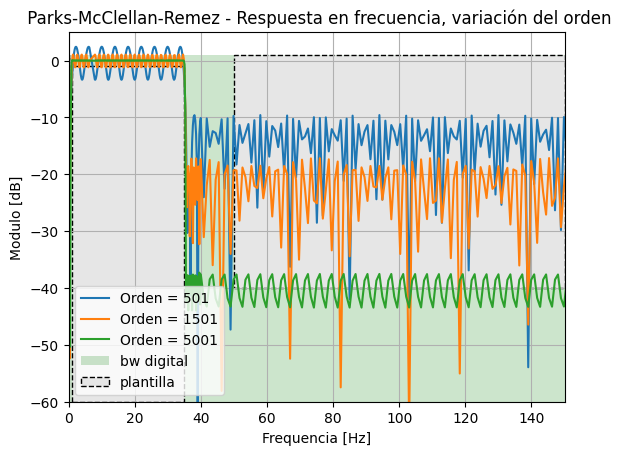

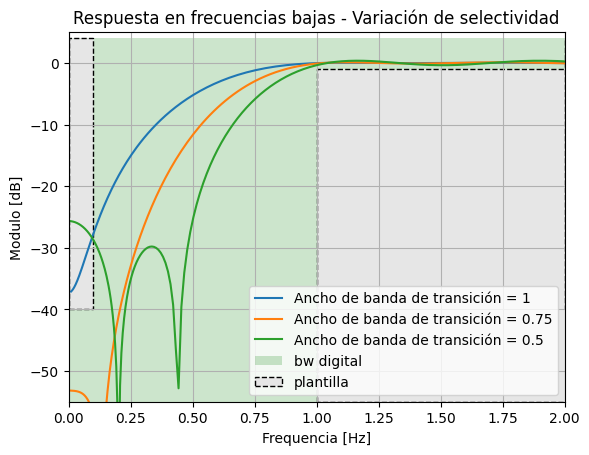

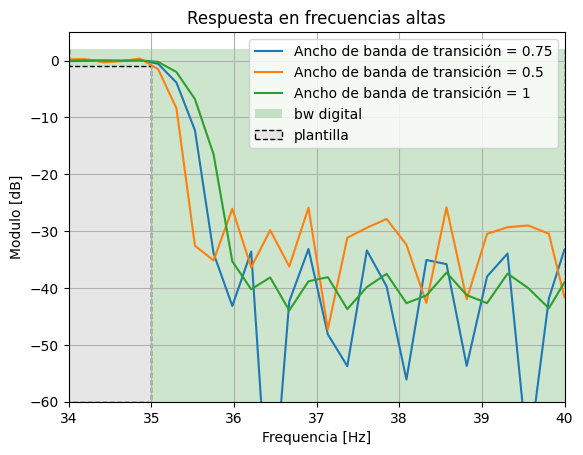

In [4]:
import numpy as np
from scipy import signal as sig

import matplotlib.pyplot as plt
   
import scipy.io as sio
from scipy.io.wavfile import write
from pytc2.sistemas_lineales import plot_plantilla


def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

fs_ecg = 1000 # Hz
sio.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')
ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])
N = len(ecg_one_lead)
nyq_frec = fs_ecg/2
ripple = 1 # dB
atenuacion = 40 # dB

ws1 = 0.1 # Hz
wp1 = 1.0 # Hz
wp2 = 35 # Hz
ws2 = 50 # Hz
frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])

gains = 10**(gains/20)
band = [1, 35]  
trans_width = 0.5    # Width of transition from pass to stop, Hz
numtaps = 2501         # Size of the FIR filter.
edges = [0, band[0] - trans_width, band[0], band[1], band[1] + trans_width , 0.5*fs_ecg]


edgesT1 = [0, band[0] - 1, band[0], band[1], band[1] + 1 , 0.5*fs_ecg]
edgesT2 = [0, band[0] - 0.75, band[0], band[1], band[1] + 0.75 , 0.5*fs_ecg]
edgesT3 = [0, band[0] - 0.5, band[0], band[1], band[1] + 0.5 , 0.5*fs_ecg]
num_remezT1 = sig.remez(numtaps, edgesT1, [0.01, 1, 0.01], fs=fs_ecg) # (20⋅log(0.01)=-40dB
num_remezT2 = sig.remez(numtaps, edgesT2, [0.01, 1, 0.01], fs=fs_ecg) # (20⋅log(0.01)=-40dB
num_remezT3 = sig.remez(numtaps, edgesT3, [0.01, 1, 0.01], fs=fs_ecg) # (20⋅log(0.01)=-40dB

numtaps1 = 501
numtaps2 = 1501
numtaps3 = 5001

num_remezO1 = sig.remez(numtaps1, edges, [0.01, 1, 0.01], fs=fs_ecg) # (20⋅log(0.01)=-40dB
num_remezO2 = sig.remez(numtaps2, edges, [0.01, 1, 0.01], fs=fs_ecg) # (20⋅log(0.01)=-40dB
num_remezO3 = sig.remez(numtaps3, edges, [0.01, 1, 0.01], fs=fs_ecg) # (20⋅log(0.01)=-40dB

den = 1.0

#Análisis:
    
NN = 1024
w_rad  = np.append(np.logspace(-2, 0.8, NN//4), np.logspace(0.9, 1.6, NN//4) )
w_rad  = np.append(w_rad, np.linspace(40, nyq_frec, NN//2, endpoint=True) ) / nyq_frec * np.pi

w, hh_remezT1 = sig.freqz(num_remezT1, den, worN=w_rad)
w, hh_remezT2 = sig.freqz(num_remezT2, den, worN=w_rad)
w, hh_remezT3 = sig.freqz(num_remezT3, den, worN=w_rad)
w, hh_remezO1 = sig.freqz(num_remezO1, den, worN=w_rad)
w, hh_remezO2 = sig.freqz(num_remezO2, den, worN=w_rad)
w, hh_remezO3 = sig.freqz(num_remezO3, den, worN=w_rad)

w = w / np.pi * nyq_frec  

plt.figure(1)
plt.title(' Parks-McClellan-Remez - Respuesta en frecuencia, variación del orden')
plt.plot(w, 20 * np.log10(abs(hh_remezO1)), label='Orden = 501')
plt.plot(w, 20 * np.log10(abs(hh_remezO2)), label='Orden = 1501')
plt.plot(w, 20 * np.log10(abs(hh_remezO3)), label='Orden = 5001')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.gca().legend()
plt.grid()
plt.axis([0, 150, -60, 1 ]);
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs_ecg)

plt.figure(2)
plt.plot(w, 20 * np.log10(abs(hh_remezT1)), label='Ancho de banda de transición = 1')
plt.plot(w, 20 * np.log10(abs(hh_remezT2)), label='Ancho de banda de transición = 0.75')
plt.plot(w, 20 * np.log10(abs(hh_remezT3)), label='Ancho de banda de transición = 0.5')
plt.title('Respuesta en frecuencias bajas - Variación de selectividad')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.gca().legend()
plt.grid()
plt.axis([0, 2, -55, 4 ]);
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs_ecg)


plt.figure(3)
plt.plot(w, 20 * np.log10(abs(hh_remezT2)), label='Ancho de banda de transición = 0.75')
plt.plot(w, 20 * np.log10(abs(hh_remezT3)), label='Ancho de banda de transición = 0.5')
plt.plot(w, 20 * np.log10(abs(hh_remezT1)), label='Ancho de banda de transición = 1')
plt.title('Respuesta en frecuencias altas')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.gca().legend()
plt.grid()
plt.axis([34, 40, -60, 2 ]);
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs_ecg)


Para optimizar el filtro FIR diseñado por el método de Parks-McClellan-Remez, se variaron dos parámetros cruciales: orden y ancho de transición. 
Como es de esperarse, mejorar el orden produce un filtro que logra una atenuación más cercana a la deseada, con menor variación en la banda de rechazo. Por otro lado, la función permite variar el ancho de la transición, permitiendo lograr un filtro más o menos selectivo según el valor elegido. Gracias a las figuras obtenidas, podemos observar que una banda de transición de 0,5 Hz asegura lograr la atenuación deseada de -40 dB en 0.1 Hz. Sin embargo, a medida que se disminuye el ancho de transición, el orden necesario para lograr la atenuación deseada resulta ser mayor. Asimismo, se encontró que la función tenía un límite de orden de alrededor de 4800 para una trnasición de 0,5 Hz.
Las pruebas realizadas permitieron diseñar un filtro que si bien tiene un alto costo computacional, logra cumplir con los requerimientos de la plantilla de diseño. 


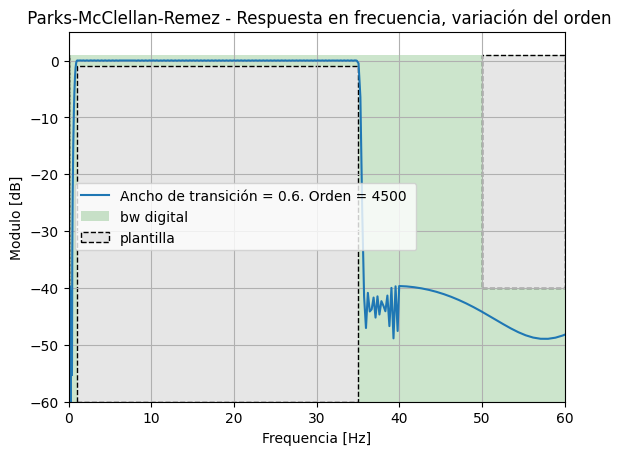

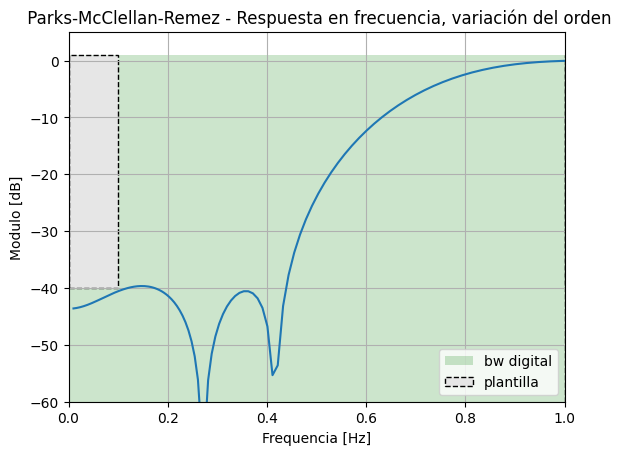

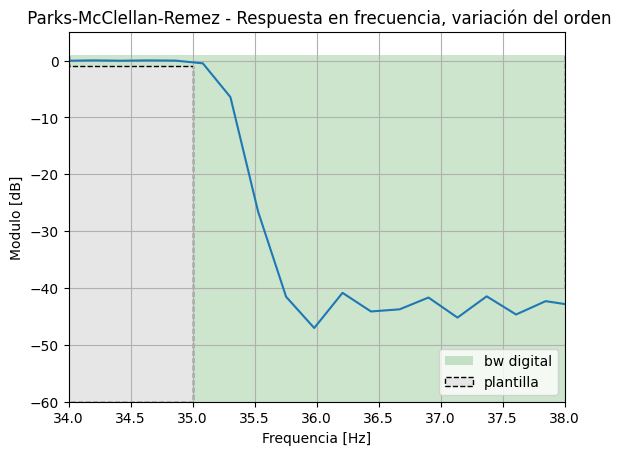

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jun 10 17:47:28 2025

@author: iremo
"""

import numpy as np
from scipy import signal as sig

import matplotlib.pyplot as plt
   
import scipy.io as sio
from scipy.io.wavfile import write
from pytc2.sistemas_lineales import plot_plantilla


def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

fs_ecg = 1000 # Hz
sio.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')
ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])
N = len(ecg_one_lead)
nyq_frec = fs_ecg/2
ripple = 1 # dB
atenuacion = 40 # dB

ws1 = 0.1 # Hz
wp1 = 1.0 # Hz
wp2 = 35 # Hz
ws2 = 50 # Hz
frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])

gains = 10**(gains/20)
band = [1, 35]  
trans_width = 0.6   # Width of transition from pass to stop, Hz
numtaps = 4501         # Size of the FIR filter.
edges = [0, band[0] - trans_width, band[0], band[1], band[1] + trans_width , 0.5*fs_ecg]


num_remez = sig.remez(numtaps, edges, [0.01, 1, 0.007], fs=fs_ecg) # (20⋅log(0.01)=-40dB

den = 1.0

#Análisis:
    
NN = 1024
w_rad  = np.append(np.logspace(-2, 0.8, NN//4), np.logspace(0.9, 1.6, NN//4) )
w_rad  = np.append(w_rad, np.linspace(40, nyq_frec, NN//2, endpoint=True) ) / nyq_frec * np.pi

w, hh_remez = sig.freqz(num_remez, den, worN=w_rad)
w = w / np.pi * nyq_frec  

plt.figure(1)
plt.title(' Parks-McClellan-Remez - Respuesta en frecuencia, variación del orden')
plt.plot(w, 20 * np.log10(abs(hh_remez)),label='Ancho de transición = 0.6. Orden = 4500 ')

plt.xlabel('Frequencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.grid()
plt.axis([0, 60, -60, 1 ]);
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs_ecg)
plt.figure(2)
plt.title(' Parks-McClellan-Remez - Respuesta en frecuencia, variación del orden')
plt.plot(w, 20 * np.log10(abs(hh_remez)))
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.grid()
plt.axis([0 , 1, -60, 1 ]);
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs_ecg)

plt.figure(3)
plt.title(' Parks-McClellan-Remez - Respuesta en frecuencia, variación del orden')
plt.plot(w, 20 * np.log10(abs(hh_remez)))
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.grid()
plt.axis([34,38, -60, 1 ]);
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs_ecg)


Como se logra apreciar, este último diseño requiere un orden muy alto porque el ancho de las bandas de transición es muy angosto. Para reducir el orden total, una excelente idea es dividir el diseño en dos etapas FIR en cascada:Un pasaaltos FIR con transición ajustada de 0.1 Hz a 1 Hz y un pasabajos FIR con transición de 35 Hz a 50 Hz. Así, cada filtro solo se preocupa por una transición, y el producto de sus respuestas da el filtro pasabanda deseado pero mucho menos exigido en cuanto al orden y por lo tanto al costo computacional.

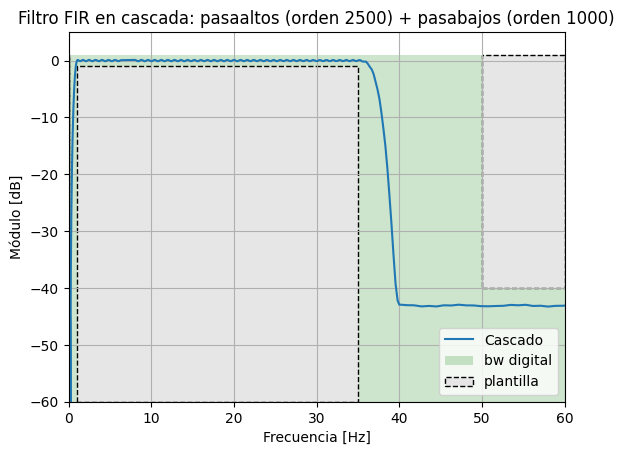

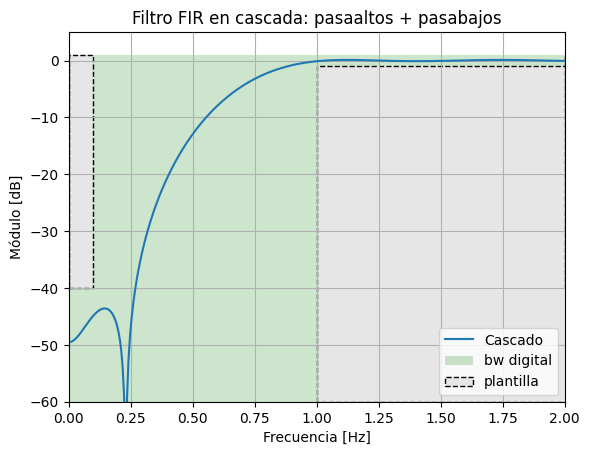

In [6]:

import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla

def vertical_flaten(a):
    return a.reshape(a.shape[0], 1)

# Cargar señal ECG
fs_ecg = 1000  # Hz
mat_struct = sio.loadmat('ecg.mat')
ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])

# Parámetros de plantilla
nyq_frec = fs_ecg / 2
ripple = 1  # dB
atenuacion = 40  # dB

# Frecuencias
ws1 = 0.1  # Hz
wp1 = 1.0  # Hz
wp2 = 35   # Hz
ws2 = 50   # Hz


numtaps_hp = 2501 
trans_width = 0.7
band = [1, 35]  
edges_hp = [0, band[0] - trans_width , band[0],  0.5*fs_ecg]
desired_hp = [0.01,1] 
num_hp = sig.remez(numtaps_hp, edges_hp, desired_hp, fs=fs_ecg)


numtaps_lp = 1001
trans_width = 5
edges_lp = [0, wp2, wp2+trans_width, 0.5*fs_ecg]
desired_lp = [1, 0.007]
num_lp = sig.remez(numtaps_lp, edges_lp, desired_lp, fs=fs_ecg)


num_cascado = np.convolve(num_hp, num_lp)
den = 1.0

# === Respuesta en frecuencia ===
NN = 1024
w_rad = np.append(np.logspace(-2, 0.8, NN//4),
                  np.logspace(0.9, 1.6, NN//4))
w_rad = np.append(w_rad, np.linspace(40, nyq_frec, NN//2, endpoint=True)) / nyq_frec * np.pi

w, hh = sig.freqz(num_cascado, den, worN=w_rad)
w = w / np.pi * nyq_frec

# === Graficar ===
plt.figure(1)
plt.title('Filtro FIR en cascada: pasaaltos (orden 2500) + pasabajos (orden 1000)')
plt.plot(w, 20 * np.log10(np.abs(hh)), label='Cascado')
plt.grid()
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.legend()
plt.axis([0, 60, -60, 1])
plot_plantilla(filter_type='bandpass',
               fpass=[wp1, wp2],
               fstop=[ws1, ws2],
               ripple=ripple,
               attenuation=atenuacion,
               fs=fs_ecg)
plt.figure(2)
plt.title('Filtro FIR en cascada: pasaaltos + pasabajos')
plt.plot(w, 20 * np.log10(np.abs(hh)), label='Cascado')
plt.grid()
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.legend()
plt.axis([0, 2, -60, 1])
plot_plantilla(filter_type='bandpass',
               fpass=[wp1, wp2],
               fstop=[ws1, ws2],
               ripple=ripple,
               attenuation=atenuacion,
               fs=fs_ecg)


Como se anticipó previamente, se concatenaron dos filtros, un pasa altos, para filtrar entre 0 y 1 Hz y un pasa bajos para filtrar entre 35 y 50 Hz. Observamos como esto permite producir un filtro que cumple con las especificaciones de la plantilla sin demasiado esfuerzo utilizando un orden mucho mejor que el pasabanda anterior, con un costo computacional mucho más bajo.

### 2.2 Filtrado y evaluación de rendimiento
Una vez diseñados los filtros a utilizar, resta verificar que filtren correctamente en las regiones con interferencias. Las señales con filtro deberían tener menor amplitud de interferencia, además, las señales filtradas deberían parecerse mucho al ECG original en las regiones sin ruido. 
Para filtrar correctamente la señal, es necesario aplicar los filtros diseñados, para ello, se decidió utilizar la función **scipy.signal.filtfilt** que aplica el filtro digital dos veces, la primera vez en el sentido normal del tiempo, y la segunda vez en el sentido inverso. Esta técnica resulta ventajosa ya que cancela el retardo de fase porque el efecto de avance y retroceso se compensan, dejando una señal filtrada con fase cero (sin desfase). En señales como la de ECG, mantener la forma de onda es fundamental, por este motivo, tener una fase nula es crucial para no generar distorsión.
Para los IIR ((Butter, Cheby, Cauer), se utiliza sosfiltfilt ya que estos fueron definidos en formato sos.
Los filtros diseñados deberían:
1. Filtrar señales interferentes.
2. No producir un efecto no deseado en zonas no interferentes.
Por este motivo, estudiará la señal filtrada mediante los diversos filtros diseñados en dos regiones: una región ruidosa en donde se analizará la efectividad del filtrado, y una región no ruidosa, en dodne el filtro debería no alterar la señal original.

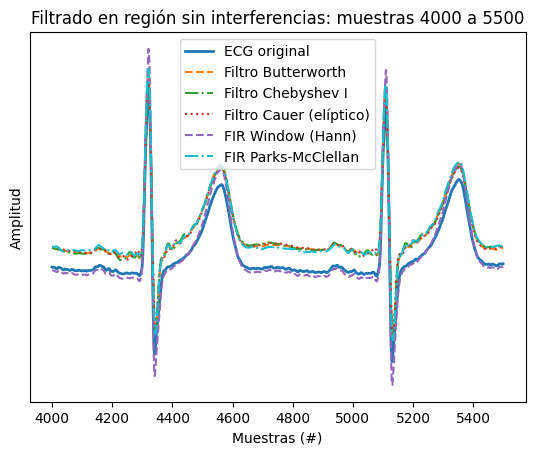

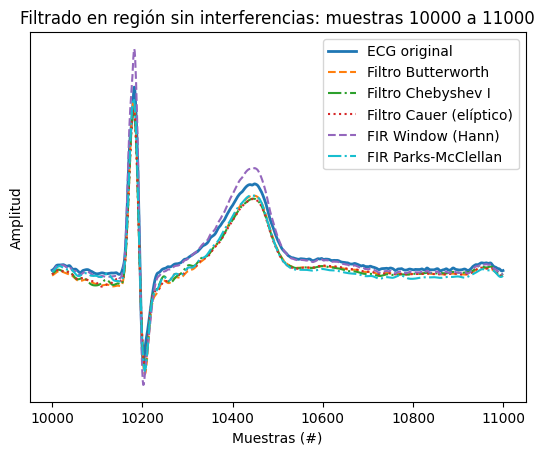

In [7]:
"""
Created on Tue Jun 10 17:47:28 2025

@author: iremo
"""

import numpy as np
from scipy import signal as sig

import matplotlib.pyplot as plt
   
import scipy.io as sio
from scipy.io.wavfile import write
from pytc2.sistemas_lineales import plot_plantilla
from scipy.signal import sosfiltfilt, filtfilt

def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

#%%


fs_ecg = 1000 # Hz


# ECG con ruido


# para listar las variables que hay en el archivo
sio.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])
N = len(ecg_one_lead)

 
nyq_frec = fs_ecg/2
ripple = 1 # dB
atenuacion = 40 # dB
 
ws1 = 0.1 # Hz
wp1 = 1.0 # Hz
wp2 = 35 # Hz
ws2 = 50 # Hz
 
# plantilla normalizada a Nyquist en dB
frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
# convertimos a veces para las funciones de diseño
gains = 10**(gains/20)

#Para el remez cascadeado
numtaps_hp = 2501 
trans_width = 0.7
band = [1, 35]  
edges_hp = [0, band[0] - trans_width , band[0],  0.5*fs_ecg]
desired_hp = [0.01,1] 
num_hp = sig.remez(numtaps_hp, edges_hp, desired_hp, fs=fs_ecg)
numtaps_lp = 1001
trans_width = 5
edges_lp = [0, wp2, wp2+trans_width, 0.5*fs_ecg]
desired_lp = [1, 0.007]
num_lp = sig.remez(numtaps_lp, edges_lp, desired_lp, fs=fs_ecg)
num_cascado = np.convolve(num_hp, num_lp)


#Diseño de filtros

bp_sos_butter = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=0.5, gstop=40., analog=False, ftype='butter', output='sos')
bp_sos_cheby = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=0.5, gstop=40., analog=False, ftype='cheby1', output='sos')
bp_sos_cauer = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=0.5, gstop=40., analog=False, ftype='ellip', output='sos')

cant_coef = 3001 #para ventanas

gains = 10**(gains/20)

num_win =   sig.firwin2(cant_coef, frecs, gains , window ='hann' )

den = 1.0



# Filtros IIR con fase cero
ECG_f_butt  = sosfiltfilt(bp_sos_butter, ecg_one_lead.flatten())
ECG_f_cheby = sosfiltfilt(bp_sos_cheby, ecg_one_lead.flatten())
ECG_f_cauer = sosfiltfilt(bp_sos_cauer, ecg_one_lead.flatten())

# Filtros FIR con fase cero

ECG_f_remez = filtfilt(num_cascado, den, ecg_one_lead.flatten())
ECG_f_win   = filtfilt(num_win,   den, ecg_one_lead.flatten())

estilos = {
    'original': {'color': 'tab:blue', 'linestyle': '-', 'label': 'ECG original', 'linewidth': 2},
    'butter':   {'color': 'tab:orange', 'linestyle': '--', 'label': 'Filtro Butterworth'},
    'cheby':    {'color': 'tab:green', 'linestyle': '-.', 'label': 'Filtro Chebyshev I'},
    'cauer':    {'color': 'tab:red', 'linestyle': ':', 'label': 'Filtro Cauer (elíptico)'},
    'hann':     {'color': 'tab:purple', 'linestyle': '--', 'label': 'FIR Window (Hann)'},
    'remez':    {'color': 'tab:cyan', 'linestyle': '-.', 'label': 'FIR Parks-McClellan'}
}

regs_interes = ([4000, 5500],[10_000, 11_000],
        )

for ii in regs_interes:
    # Intervalo acotado dentro del rango de datos
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([N, ii[1]]), dtype='uint')

    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region],**estilos['original'])
    plt.plot(zoom_region, ECG_f_butt[zoom_region],  **estilos['butter'])
    plt.plot(zoom_region, ECG_f_cheby[zoom_region], **estilos['cheby'])
    plt.plot(zoom_region, ECG_f_cauer[zoom_region], **estilos['cauer'])
    plt.plot(zoom_region, ECG_f_win[zoom_region],**estilos['hann'])
    plt.plot(zoom_region, ECG_f_remez[zoom_region],  **estilos['remez'])

    plt.title(f'Filtrado en región sin interferencias: muestras {int(ii[0])} a {int(ii[1])}')
    plt.ylabel('Amplitud')
    plt.xlabel('Muestras (#)')
    plt.legend()
    plt.yticks([])
    plt.show()
    

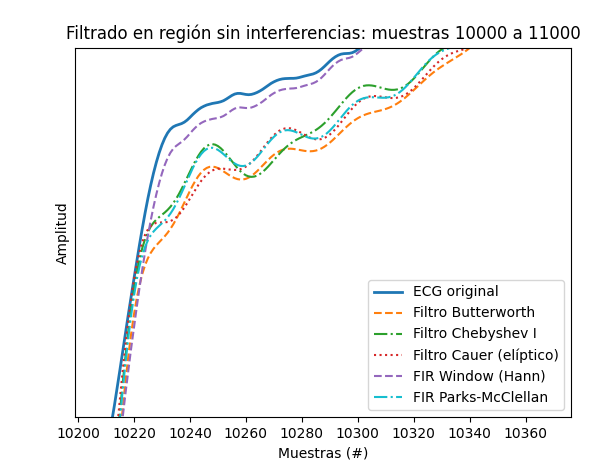
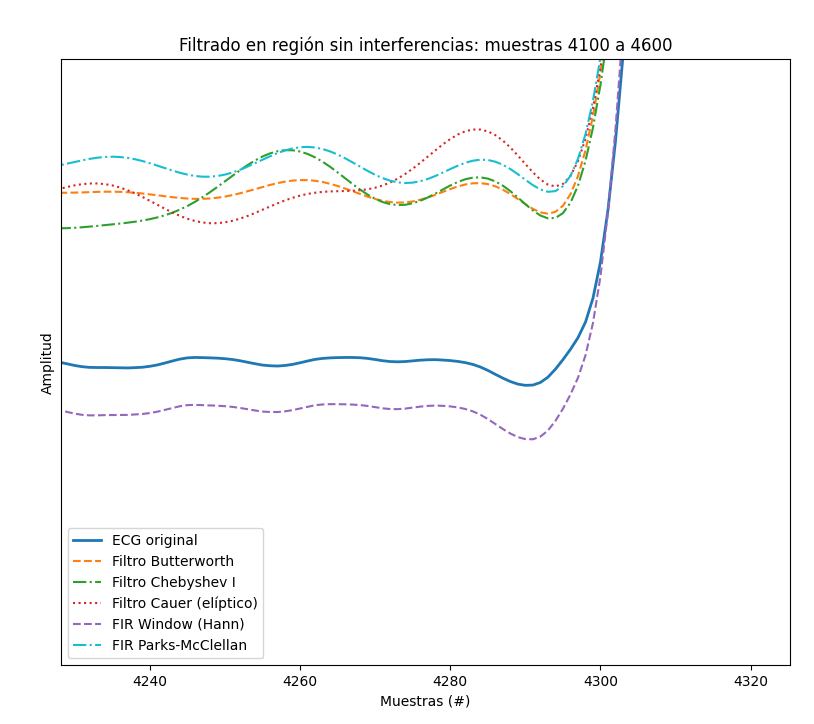

En primer lugar evaluamos la fidelidad de la señal filtrada respecto a la original evaluando en regiones sin interferencias, se observa que el filtrado mediante el método de ventanas produce la señal que más se acerca a la original, la señal filtrada con el filtro de Butter también produce una señal bastante cercana a la original en cuanto a su forma, sin embargo, su amplitud difiere ligeramente. Los filtros de Cheby, Cauer y Parks-McClellan producen una señal cercana a la original pero que no respeta con tanta fidelidad la forma de onda original, sino que producen ligeras ondulaciones, lo cual es esperable ya que, como se vió en la plantilla de diseño, presentan ripple en la banda de paso. 

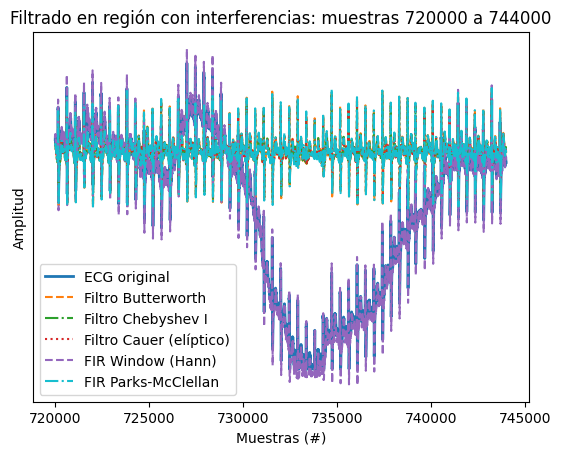

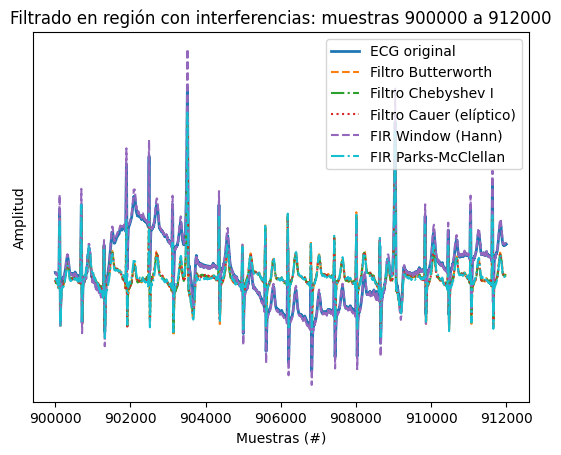

In [14]:
"""
Created on Tue Jun 10 17:47:28 2025

@author: iremo
"""

import numpy as np
from scipy import signal as sig

import matplotlib.pyplot as plt
   
import scipy.io as sio
from scipy.io.wavfile import write
from pytc2.sistemas_lineales import plot_plantilla
from scipy.signal import sosfiltfilt, filtfilt

def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

#%%


fs_ecg = 1000 # Hz


# ECG con ruido


# para listar las variables que hay en el archivo
sio.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])
N = len(ecg_one_lead)

 
nyq_frec = fs_ecg/2
ripple = 1 # dB
atenuacion = 40 # dB
 
ws1 = 0.1 # Hz
wp1 = 1.0 # Hz
wp2 = 35 # Hz
ws2 = 50 # Hz
 
# plantilla normalizada a Nyquist en dB
frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
# convertimos a veces para las funciones de diseño
gains = 10**(gains/20)

#Para el remez cascadeado
numtaps_hp = 2501 
trans_width = 0.7
band = [1, 35]  
edges_hp = [0, band[0] - trans_width , band[0],  0.5*fs_ecg]
desired_hp = [0.01,1] 
num_hp = sig.remez(numtaps_hp, edges_hp, desired_hp, fs=fs_ecg)
numtaps_lp = 1001
trans_width = 5
edges_lp = [0, wp2, wp2+trans_width, 0.5*fs_ecg]
desired_lp = [1, 0.007]
num_lp = sig.remez(numtaps_lp, edges_lp, desired_lp, fs=fs_ecg)
num_cascado = np.convolve(num_hp, num_lp)


#Diseño de filtros

bp_sos_butter = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=0.5, gstop=40., analog=False, ftype='butter', output='sos')
bp_sos_cheby = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=0.5, gstop=40., analog=False, ftype='cheby1', output='sos')
bp_sos_cauer = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=0.5, gstop=40., analog=False, ftype='ellip', output='sos')

cant_coef = 3001 #para ventanas

gains = 10**(gains/20)

num_win =   sig.firwin2(cant_coef, frecs, gains , window ='hann' )

den = 1.0



# Filtros IIR con fase cero
ECG_f_butt  = sosfiltfilt(bp_sos_butter, ecg_one_lead.flatten())
ECG_f_cheby = sosfiltfilt(bp_sos_cheby, ecg_one_lead.flatten())
ECG_f_cauer = sosfiltfilt(bp_sos_cauer, ecg_one_lead.flatten())

# Filtros FIR con fase cero

ECG_f_remez = filtfilt(num_cascado, den, ecg_one_lead.flatten())
ECG_f_win   = filtfilt(num_win,   den, ecg_one_lead.flatten())

estilos = {
    'original': {'color': 'tab:blue', 'linestyle': '-', 'label': 'ECG original', 'linewidth': 2},
    'butter':   {'color': 'tab:orange', 'linestyle': '--', 'label': 'Filtro Butterworth'},
    'cheby':    {'color': 'tab:green', 'linestyle': '-.', 'label': 'Filtro Chebyshev I'},
    'cauer':    {'color': 'tab:red', 'linestyle': ':', 'label': 'Filtro Cauer (elíptico)'},
    'hann':     {'color': 'tab:purple', 'linestyle': '--', 'label': 'FIR Window (Hann)'},
    'remez':    {'color': 'tab:cyan', 'linestyle': '-.', 'label': 'FIR Parks-McClellan'}
}
regs_interes = (
        np.array([12, 12.4]) *60*fs_ecg, # minutos a muestras
        np.array([15, 15.2]) *60*fs_ecg, # minutos a muestras
        )
for ii in regs_interes:
    # Intervalo acotado dentro del rango de datos
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([N, ii[1]]), dtype='uint')

    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region],**estilos['original'])
    # Solo se muestra el filtro FIR para evaluar inocuidad (puedes cambiar a Butterworth si prefieres)
    plt.plot(zoom_region, ECG_f_butt[zoom_region],  **estilos['butter'])
    plt.plot(zoom_region, ECG_f_cheby[zoom_region], **estilos['cheby'])
    plt.plot(zoom_region, ECG_f_cauer[zoom_region], **estilos['cauer'])
    plt.plot(zoom_region, ECG_f_win[zoom_region],**estilos['hann'])
    plt.plot(zoom_region, ECG_f_remez[zoom_region],  **estilos['remez'])

    plt.title(f'Filtrado en región con interferencias: muestras {int(ii[0])} a {int(ii[1])}')
    plt.ylabel('Amplitud')
    plt.xlabel('Muestras (#)')
    plt.legend()
    plt.yticks([])
    plt.show()

Finalmente, se evaluaron los filtros en regiones altamente contaminadas, observándose que, salvo el filtro FIR implementado mediante el método de ventanas, todos los filtros fueron capaces de atenuar eficazmente las señales interferentes. En base a los resultados obtenidos, se concluye que el filtro más apto para el procesamiento de señales de ECG es el filtro de Butterworth. Esta elección se fundamenta en varias ventajas clave: su bajo orden, que se traduce en una menor complejidad computacional; la posibilidad de implementación eficiente mediante la factorización en forma de matriz SOS (Second-Order Sections); y su gran planicidad en la banda de paso, lo cual permite preservar fielmente la forma de onda de la señal original. Además, el filtro de Butterworth no presenta ripple en la banda de paso ni en la de atenuación, lo que asegura una respuesta suave y estable. A pesar de su bajo orden, demuestra una selectividad relativamente alta, suficiente para separar las componentes de interés de las interferencias sin introducir distorsiones significativas. Esta combinación de bajo costo computacional, facilidad de implementación, estabilidad y desempeño efectivo frente a interferencias hace de este filtro una opción robusta para el filtrado de señales de ECG en condiciones de ruido como lo es el caso de una prueba de esfuerzo. 
Sin embargo, cabe destacar que si bien de los filtros utilizados el Butterworth produjo los mejores resultados, introduce ligeras diferencias de amplitud y forma respecto a la señal original. Por este motivo, en aplicaciones donde la preservación de la morfología de la señal debe ser estrictamente preservada, es conveniente utilizar técnicas de filtrado capaces de introducir menores distorsiones.